Methods for denoising spectra

Simulated spectra with a single Lorentzian feature are generated and methods to denoise the spectra are explored. 

Recurrent neural networks (RNNs) are like feedforward neural networks with feedback loops (backpropagation) through time. RNNs are generally used for image captioning, language translation, etc. See http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for more information. 

1. RNNs can handle arbitrary input/output lengths
2. RNNs have been used for speech analysis (a field which also benefits from denoising)

Because of this flexibility, RNNs potentially have an advantage over other neural networks to denoise spectra. 

In this notebook, I will attempt to demonstrate denoising spectra consisting of a dataset of single Lorentzians. The Lorentzians are randomly positioned from 0 - 100 cm-1 with a 25 cm-1 width.

--- 
Future work would include training a RNN to handle a variable Lorentzian width and variable height for multiresonant spectra. 

In [0]:
# Brent DeVetter
# June 2018
# Description: denoise spectra using a recurrent neural network (RNN)
# 
# Note that the neural network is set up such that the INPUT is the 
# noisy spectra and the output is the clean spectra (i.e., it denoises the spectra)            

# References:
# 1. https://nipunbatra.github.io/blog/2018/denoising.html
# 2. https://people.xiph.org/~jm/demo/rnnoise/
# 3. http://karpathy.github.io/2015/05/21/rnn-effectiveness/
# 4. https://nbviewer.jupyter.org/github/donnemartin/data-science-ipython-notebooks/blob/master/deep-learning/keras-tutorial/3.2%20RNN%20and%20LSTM.ipynb

# Import appropriate libaries
import numpy as np
import math, random
import matplotlib.pyplot as plt
%matplotlib inline

# pyTorch for the neural network via Google Colab
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable

np.random.seed(0)

# Generate a synthetic spectra without any noise (note: intensity scaled by 100x)
def lorentzian(x, x0, width = 25):
    """ Function: lorentzian 
                x: np array of x-axis datapoints
                x0: position of peak of the lorentzian (in cm-1)
                width: width of the lorentzian (in cm-1)
    """
    return 100.0 / np.pi * 0.5 * width / ((x - x0)**2 + (0.5*width)**2)

# Adding uniform noise to spectra
def add_noise(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

# Create a clean & noisy spectra
def simulate_spectra(sample_size):
    x_offset = random.randint(0, sample_size)
    wavenumber = np.arange(sample_size)
    y_clean = lorentzian(wavenumber, x_offset)
    y_noise = add_noise(y_clean)
    return y_noise, y_clean

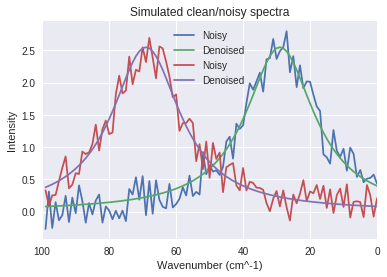

In [46]:
# Check that spectra generation is functioning
# In this example, spectra consist of a single 25 cm-1 Lorentzian

spectra1_noise, spectra1_clean = simulate_spectra(100)
spectra2_noise, spectra2_clean = simulate_spectra(100)

plt.plot(spectra1_noise, label='Noisy')
plt.plot(spectra1_clean, label ='Denoised')
plt.plot(spectra2_noise, label='Noisy')
plt.plot(spectra2_clean, label ='Denoised')
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Intensity')
plt.xlim(100, 0)
plt.title('Simulated clean/noisy spectra')
plt.legend()

In [0]:
def create_dataset(n_samples=10000, sample_size=100):
    y_noise = np.zeros((n_samples, sample_size))
    y_clean = np.zeros((n_samples, sample_size))
    
    for i in range(n_samples):
        sample_noise, sample_clean = simulate_spectra(sample_size)
        y_noise[i, :] = sample_noise
        y_clean[i, :] = sample_clean
    return y_noise, y_clean

In [48]:
# Split the dataset into a training and test set 
y_noise, y_clean = create_dataset()
y_noise_train, y_clean_train = y_noise[:9000], y_clean[:9000]
y_noise_test,  y_clean_test = y_noise[9000:], y_clean[9000:]

print("Size of training set {0}; Size of test set {1}".format(y_noise_train.shape, y_noise_test.shape))

Size of training set (9000, 100); Size of test set (1000, 100)


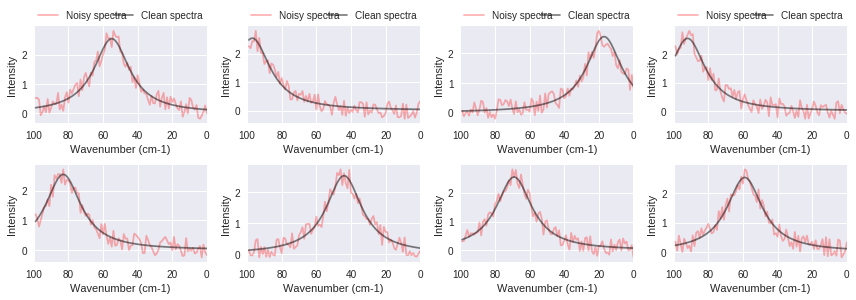

In [49]:
# Show a panel of several spectra from the training set with and without noise
f, ax = plt.subplots(2,4,figsize=(12,4))
wavenumber = np.arange(100)

plt.subplot(241)
plt.plot(wavenumber, y_noise[0], color='r', alpha=0.3, label='Noisy spectra')
plt.plot(wavenumber, y_clean[0], color='k', alpha=0.5, label='Clean spectra')
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlim(100, 0)

plt.subplot(242)
plt.plot(wavenumber, y_noise[1], color='r', alpha=0.3, label='Noisy spectra')
plt.plot(wavenumber, y_clean[1], color='k', alpha=0.5, label='Clean spectra')
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlim(100, 0)

plt.subplot(243)
plt.plot(wavenumber, y_noise[2], color='r', alpha=0.3, label='Noisy spectra')
plt.plot(wavenumber, y_clean[2], color='k', alpha=0.5, label='Clean spectra')
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlim(100, 0)

plt.subplot(244)
plt.plot(wavenumber, y_noise[3], color='r', alpha=0.3, label='Noisy spectra')
plt.plot(wavenumber, y_clean[3], color='k', alpha=0.5, label='Clean spectra')
plt.xlim(100, 0)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')


plt.subplot(245)
plt.plot(wavenumber, y_noise[4], color='r', alpha=0.3, label='Noisy spectra')
plt.plot(wavenumber, y_clean[4], color='k', alpha=0.5, label='Clean spectra')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')

plt.subplot(246)
plt.plot(wavenumber, y_noise[5], color='r', alpha=0.3, label='Noisy spectra')
plt.plot(wavenumber, y_clean[5], color='k', alpha=0.5, label='Clean spectra')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')

plt.subplot(247)
plt.plot(wavenumber, y_noise[6], color='r', alpha=0.3, label='Noisy spectra')
plt.plot(wavenumber, y_clean[6], color='k', alpha=0.5, label='Clean spectra')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')

plt.subplot(248)
plt.plot(wavenumber, y_noise[7], color='r', alpha=0.3, label='Noisy spectra')
plt.plot(wavenumber, y_clean[7], color='k', alpha=0.5, label='Clean spectra')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.tight_layout()

In [50]:
# Create a RNN using pyTorch
# I found that a ReLU6 activation function 
# was significantly better at reproducing a Lorentzian feature as 
# compared to tanh 

input_dim = 1
hidden_size = 30
num_layers = 1

class myRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(myRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.ReLU6() #nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= myRNN(input_dim, hidden_size, 1)
print(r)

myRNN(
  (rnn): RNN(1, 30, batch_first=True)
  (linear): Linear(in_features=30, out_features=1)
  (act): ReLU6()
)


In [51]:
# Train the neural net
loss_tracker = []
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(401):
    hidden = None
    inp = Variable(torch.Tensor(y_noise_train.reshape((y_noise_train.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(y_clean_train.reshape((y_clean_train.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print("Epoch: {0}, Loss: {1}".format(t, loss.data[0]))
        loss_tracker.append(loss.data[0])
    loss.backward()
    optimizer.step()

Epoch: 0, Loss: 0.6906546354293823
Epoch: 20, Loss: 0.14425751566886902
Epoch: 40, Loss: 0.11800920963287354
Epoch: 60, Loss: 0.1079385057091713
Epoch: 80, Loss: 0.1000855565071106
Epoch: 100, Loss: 0.09257473051548004
Epoch: 120, Loss: 0.1440679281949997
Epoch: 140, Loss: 0.10671085119247437
Epoch: 160, Loss: 0.0912245586514473
Epoch: 180, Loss: 0.08449326455593109
Epoch: 200, Loss: 0.08508936315774918
Epoch: 220, Loss: 0.07637783139944077
Epoch: 240, Loss: 0.0957953929901123
Epoch: 260, Loss: 0.09159324318170547
Epoch: 280, Loss: 0.08318734914064407
Epoch: 300, Loss: 0.08119019120931625
Epoch: 320, Loss: 0.07871383428573608
Epoch: 340, Loss: 0.09542103111743927
Epoch: 360, Loss: 0.07004594057798386
Epoch: 380, Loss: 0.08794072270393372
Epoch: 400, Loss: 0.06643825769424438


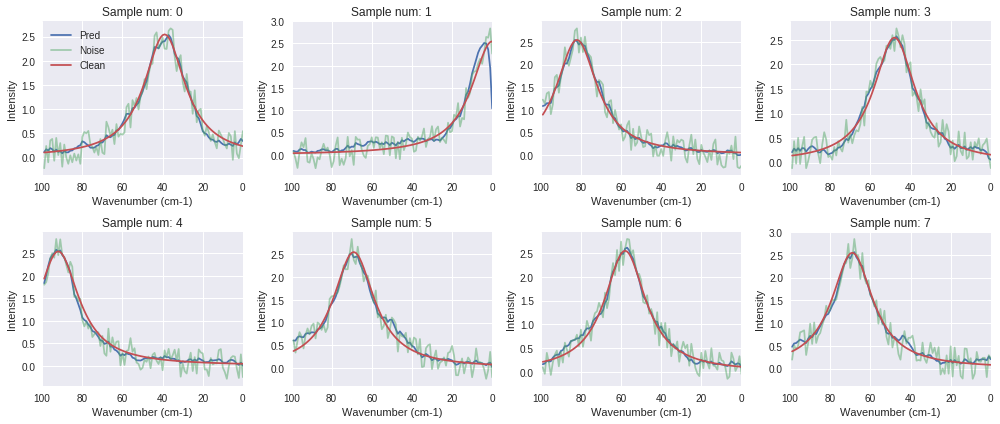

In [57]:
# Test the neural net
t_inp = Variable(torch.Tensor(y_noise_test.reshape((y_noise_test.shape[0], -1, 1))), requires_grad=True)
pred_t = r(t_inp)

f, ax = plt.subplots(2,4,figsize=(14,6))

plt.subplot(241)
sample_num = 0
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(y_noise_test[sample_num], label='Noise', alpha = 0.5)
plt.plot(y_clean_test[sample_num], label='Clean')
plt.legend()
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))

plt.subplot(242)
sample_num = 1
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(y_noise_test[sample_num], label='Noise', alpha = 0.5)
plt.plot(y_clean_test[sample_num], label='Clean')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))

plt.subplot(243)
sample_num = 2
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(y_noise_test[sample_num], label='Noise', alpha = 0.5)
plt.plot(y_clean_test[sample_num], label='Clean')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))

plt.subplot(244)
sample_num = 3
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(y_noise_test[sample_num], label='Noise', alpha = 0.5)
plt.plot(y_clean_test[sample_num], label='Clean')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))

plt.subplot(245)
sample_num = 4
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(y_noise_test[sample_num], label='Noise', alpha = 0.5)
plt.plot(y_clean_test[sample_num], label='Clean')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))

plt.subplot(246)
sample_num = 5
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(y_noise_test[sample_num], label='Noise', alpha = 0.5)
plt.plot(y_clean_test[sample_num], label='Clean')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))

plt.subplot(247)
sample_num = 6
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(y_noise_test[sample_num], label='Noise', alpha = 0.5)
plt.plot(y_clean_test[sample_num], label='Clean')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))

plt.subplot(248)
sample_num = 7
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(y_noise_test[sample_num], label='Noise', alpha = 0.5)
plt.plot(y_clean_test[sample_num], label='Clean')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))
plt.tight_layout()

In [71]:
bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class myRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(myRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, dropout=0.1)
        self.linear = nn.Linear(hidden_size*num_directions, output_size, )
        self.act = nn.ReLU6()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= myRNN(input_dim, 20, 1)
r


myRNN(
  (rnn): RNN(1, 20, batch_first=True, dropout=0.1, bidirectional=True)
  (linear): Linear(in_features=40, out_features=1)
  (act): ReLU6()
)

In [0]:
# A single RNN still has a lot of noise. Bidirectional RNNs can help
# reduce the amount of noise. 

# Bidirectional RNNs are two independent RNNs: one looking forward in time and other
# backward.

# See https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66


predictions_bd = []

optimizer_bd = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func_bd = nn.L1Loss()

for t in range(401):
    hidden = None
    inp = Variable(torch.Tensor(y_noise_train.reshape((y_noise_train.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(y_clean_train.reshape((y_clean_train.shape[0], -1, 1))) )
    pred_bd = r(inp)
    optimizer_bd.zero_grad()
    predictions_bd.append(pred_bd.data.numpy())
    loss_bd = loss_func_bd(pred_bd, out)
    if t%20==0:
        print(t, loss_bd.data[0])
    loss_bd.backward()
    optimizer_bd.step()

0 0.7523869872093201
20 0.12356751412153244
40 0.11001426726579666
60 0.09193989634513855
80 0.07527362555265427
100 0.08095976710319519
120 0.06927969306707382
140 0.061797160655260086
160 0.06867338716983795
180 0.05834360420703888
200 0.051294952630996704
220 0.05895109474658966
240 0.04937007650732994
260 0.054367177188396454


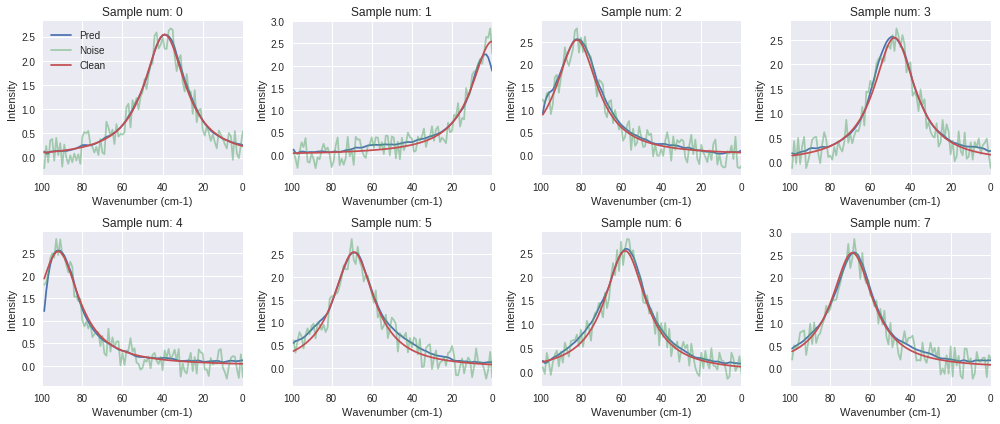

In [75]:
t_inp = Variable(torch.Tensor(y_noise_test.reshape((y_noise_test.shape[0], -1, 1))), requires_grad=True)
pred_t_bd = r(t_inp)

f, ax = plt.subplots(2,4,figsize=(14,6))

plt.subplot(241)
sample_num = 0
plt.plot(pred_t_bd[sample_num].data.numpy(), label='Pred')
plt.plot(y_noise_test[sample_num], label='Noise', alpha = 0.5)
plt.plot(y_clean_test[sample_num], label='Clean')
plt.legend()
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))

plt.subplot(242)
sample_num = 1
plt.plot(pred_t_bd[sample_num].data.numpy(), label='Pred')
plt.plot(y_noise_test[sample_num], label='Noise', alpha = 0.5)
plt.plot(y_clean_test[sample_num], label='Clean')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))

plt.subplot(243)
sample_num = 2
plt.plot(pred_t_bd[sample_num].data.numpy(), label='Pred')
plt.plot(y_noise_test[sample_num], label='Noise', alpha = 0.5)
plt.plot(y_clean_test[sample_num], label='Clean')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))

plt.subplot(244)
sample_num = 3
plt.plot(pred_t_bd[sample_num].data.numpy(), label='Pred')
plt.plot(y_noise_test[sample_num], label='Noise', alpha = 0.5)
plt.plot(y_clean_test[sample_num], label='Clean')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))

plt.subplot(245)
sample_num = 4
plt.plot(pred_t_bd[sample_num].data.numpy(), label='Pred')
plt.plot(y_noise_test[sample_num], label='Noise', alpha = 0.5)
plt.plot(y_clean_test[sample_num], label='Clean')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))

plt.subplot(246)
sample_num = 5
plt.plot(pred_t_bd[sample_num].data.numpy(), label='Pred')
plt.plot(y_noise_test[sample_num], label='Noise', alpha = 0.5)
plt.plot(y_clean_test[sample_num], label='Clean')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))

plt.subplot(247)
sample_num = 6
plt.plot(pred_t_bd[sample_num].data.numpy(), label='Pred')
plt.plot(y_noise_test[sample_num], label='Noise', alpha = 0.5)
plt.plot(y_clean_test[sample_num], label='Clean')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))

plt.subplot(248)
sample_num = 7
plt.plot(pred_t_bd[sample_num].data.numpy(), label='Pred')
plt.plot(y_noise_test[sample_num], label='Noise', alpha = 0.5)
plt.plot(y_clean_test[sample_num], label='Clean')
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))
plt.tight_layout()

Text(0.5,1,'Sample num: 0')

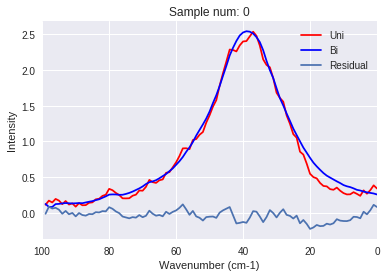

In [80]:
# Comparison of Test sample 0
sample_num = 0
plt.plot(pred_t[sample_num].data.numpy(), color='r', label='Uni')
plt.plot(pred_t_bd[sample_num].data.numpy(), color='b', label='Bi' )
plt.plot(pred_t[sample_num].data.numpy() - pred_t_bd[sample_num].data.numpy(), label='Residual')

plt.legend()
plt.xlim(100, 0)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title("Sample num: {}".format(sample_num))